In [1]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Multiply, Concatenate, Dropout
from pyod.models.knn import KNN 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestRegressor

In [2]:
data=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
data_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

In [3]:
Ntest = 1096   # 3 year
train= data.iloc[:-Ntest].copy()
test= data.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])


In [4]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

y = data_labeled.iloc[:, -1].values
ground_truth_train = y[:-Ntest].copy()
ground_truth_test = y[-Ntest:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']

### Temperature Prediction

In [6]:
var_model=VAR(train[cols])
fitted_model=var_model.fit(maxlags=50)
train_preds = fitted_model.fittedvalues['ScaledTemp']
test_preds = fitted_model.forecast(y = train[cols].values[-50:], steps= Ntest)

C:\Users\lzc-sg\Anaconda3\envs\Thesiswork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [7]:
train['Train Pred Temperature']=train_preds
test['Test Pred Temperature']=test_preds[:,0]

In [8]:
inputs = Input(shape=(50, 1))
x = inputs
for i in range(4):
    x = Conv1D(filters=12, kernel_size=3, dilation_rate=2**i, padding='causal', activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)
model_tcn = Model(inputs=inputs, outputs=x)
#model_tcn = create_tcn(input_shape=, num_filters=12, kernel_size=3, num_layers=4, num_classes=1)

In [9]:
model_tcn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

In [10]:
model_tcn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 12)            48        
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 12)            444       
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 12)            444       
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 12)            444       
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dropout (Dropout)           (None, 600)               0     

In [11]:
train_data = np.expand_dims(train['ScaledTemp'].values, -1)
x = train_data[:-50]
y = train_data[50:]
window_length = 50
X=np.zeros((x.shape[0], 50, 1))
for i in range(x.shape[0]):
    X[i] = train_data[i:i+window_length]

In [12]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model_VAR_TCN_temp_3yr.h5',
    monitor='val_loss',
    save_best_only= True,
    save_weights_only= True,
    mode= 'min'
)

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001, mode ="min" ,restore_best_weights=True)
history = model_tcn.fit(X, y, epochs=35, batch_size=64, verbose=1, validation_split=0.1, callbacks=[callback,checkpoint])

Epoch 1/35
61/61 [==============================] - 2s 13ms/step - loss: 0.2759 - val_loss: 0.1256
Epoch 2/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0935 - val_loss: 0.0553
Epoch 3/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0604 - val_loss: 0.0468
Epoch 4/35
61/61 [==============================] - 1s 8ms/step - loss: 0.0568 - val_loss: 0.0482
Epoch 5/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0548 - val_loss: 0.0546
Epoch 6/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0528 - val_loss: 0.0405
Epoch 7/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0507 - val_loss: 0.0419
Epoch 8/35
61/61 [==============================] - 1s 8ms/step - loss: 0.0481 - val_loss: 0.0413
Epoch 9/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0487 - val_loss: 0.0477
Epoch 10/35
61/61 [==============================] - 0s 8ms/step - loss: 0.0466 - val_loss: 0.0384
Epoch 11/35
61/61 

In [14]:
train_tcn_pred = model_tcn(X)

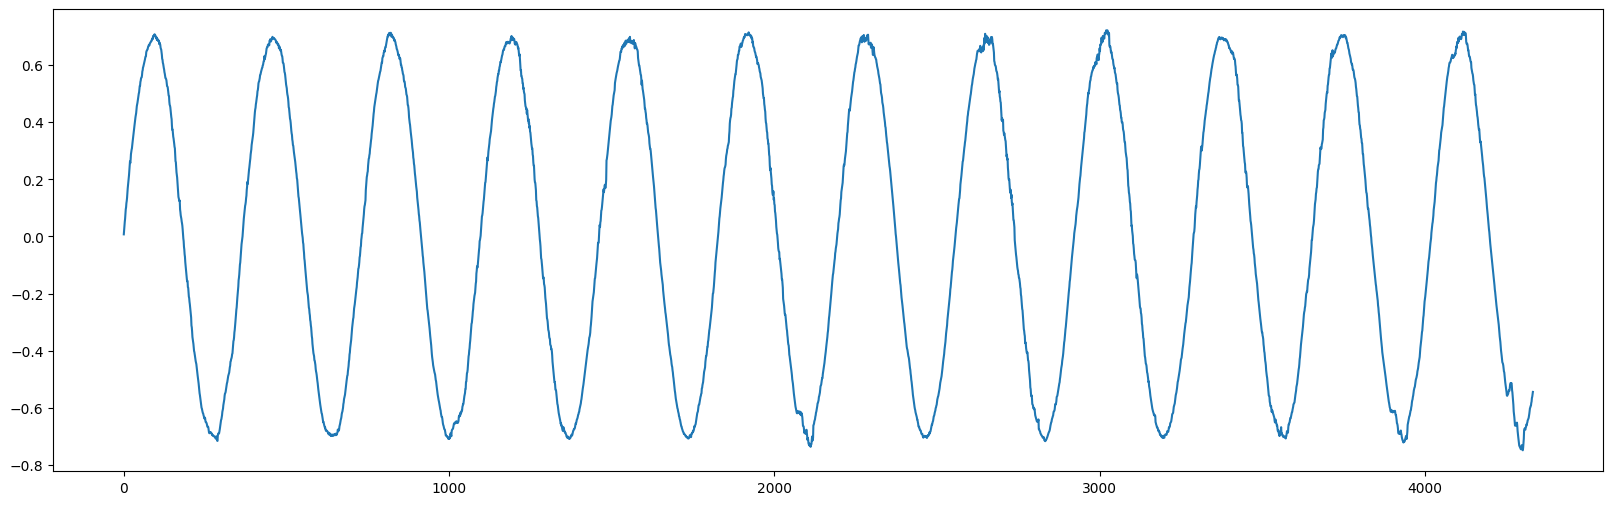

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(train_tcn_pred.numpy().squeeze())

### Humidity Prediction

In [16]:
var_model=VAR(train[cols])
fitted_model=var_model.fit(maxlags=50)
train_preds = fitted_model.fittedvalues['ScaledHumid']
test_preds = fitted_model.forecast(y = train[cols].values[-50:], steps= Ntest)

C:\Users\lzc-sg\Anaconda3\envs\Thesiswork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [17]:
train['Train Pred Humidity']=train_preds
test['Test Pred Humidity']=test_preds[:,1]

In [18]:
inputs = Input(shape=(50, 1))
x = inputs
for i in range(4):
    x = Conv1D(filters=12, kernel_size=3, dilation_rate=2**i, padding='causal', activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)
model_tcn_humid = Model(inputs=inputs, outputs=x)
#model_tcn = create_tcn(input_shape=, num_filters=12, kernel_size=3, num_layers=4, num_classes=1)

In [19]:
model_tcn_humid.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

In [20]:
model_tcn_humid.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 12)            48        
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 12)            444       
                                                                 
 conv1d_6 (Conv1D)           (None, 50, 12)            444       
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 12)            444       
                                                                 
 flatten_1 (Flatten)         (None, 600)               0         
                                                                 
 dropout_1 (Dropout)         (None, 600)               0   

In [21]:
train_data = np.expand_dims(train['ScaledHumid'].values, -1)
x = train_data[:-50]
y = train_data[50:]
window_length = 50
X=np.zeros((x.shape[0], 50, 1))
for i in range(x.shape[0]):
    X[i] = train_data[i:i+window_length]

In [22]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model_VAR_TCN_humidity_3yr.h5',
    monitor='val_loss',
    save_best_only= True,
    save_weights_only= True,
    mode= 'min'
)

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001, mode ="min" ,restore_best_weights=True)
history = model_tcn_humid.fit(X, y, epochs=35, batch_size=64, verbose=1, validation_split=0.1, callbacks=[callback,checkpoint])

Epoch 1/35
61/61 [==============================] - 2s 12ms/step - loss: 0.2273 - val_loss: 0.0869
Epoch 2/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0808 - val_loss: 0.0433
Epoch 3/35
61/61 [==============================] - 1s 8ms/step - loss: 0.0606 - val_loss: 0.0403
Epoch 4/35
61/61 [==============================] - 0s 8ms/step - loss: 0.0558 - val_loss: 0.0357
Epoch 5/35
61/61 [==============================] - 1s 8ms/step - loss: 0.0532 - val_loss: 0.0428
Epoch 6/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0515 - val_loss: 0.0416
Epoch 7/35
61/61 [==============================] - 0s 8ms/step - loss: 0.0487 - val_loss: 0.0407
Epoch 8/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0468 - val_loss: 0.0354
Epoch 9/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0452 - val_loss: 0.0337
Epoch 10/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0449 - val_loss: 0.0391
Epoch 11/35
61/61 

In [24]:
train_tcn_pred_humid = model_tcn_humid(X)

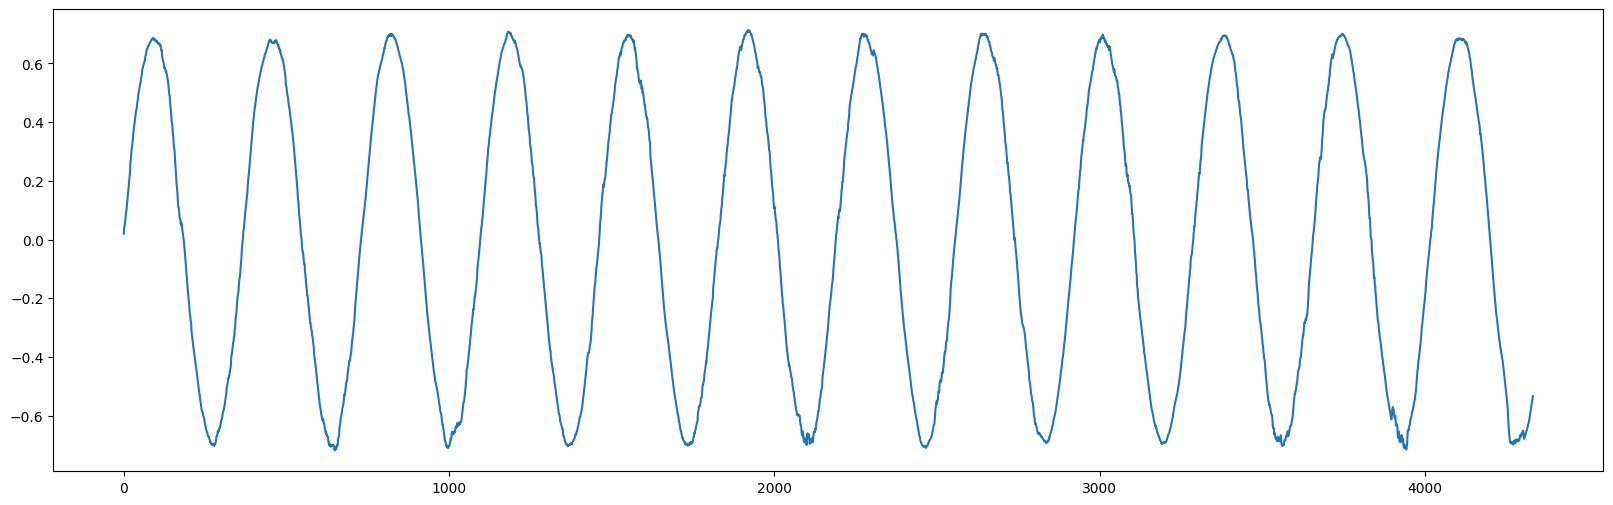

In [25]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(train_tcn_pred_humid.numpy().squeeze())

### Pressure Prediction

In [26]:
var_model=VAR(train[cols])
fitted_model=var_model.fit(maxlags=50)
train_preds = fitted_model.fittedvalues['ScaledPressure']
test_preds = fitted_model.forecast(y = train[cols].values[-50:], steps= Ntest)

C:\Users\lzc-sg\Anaconda3\envs\Thesiswork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [27]:
train['Train Pred Pressure']=train_preds
test['Test Pred Pressure']=test_preds[:,2]

In [28]:
inputs = Input(shape=(50, 1))
x = inputs
for i in range(4):
    x = Conv1D(filters=12, kernel_size=3, dilation_rate=2**i, padding='causal', activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)
model_tcn_pressure = Model(inputs=inputs, outputs=x)
#model_tcn = create_tcn(input_shape=, num_filters=12, kernel_size=3, num_layers=4, num_classes=1)

In [29]:
model_tcn_pressure.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

In [30]:
model_tcn_pressure.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 50, 12)            48        
                                                                 
 conv1d_9 (Conv1D)           (None, 50, 12)            444       
                                                                 
 conv1d_10 (Conv1D)          (None, 50, 12)            444       
                                                                 
 conv1d_11 (Conv1D)          (None, 50, 12)            444       
                                                                 
 flatten_2 (Flatten)         (None, 600)               0         
                                                                 
 dropout_2 (Dropout)         (None, 600)               0   

In [31]:
train_data = np.expand_dims(train['ScaledPressure'].values, -1)
x = train_data[:-50]
y = train_data[50:]
window_length = 50
X=np.zeros((x.shape[0], 50, 1))
for i in range(x.shape[0]):
    X[i] = train_data[i:i+window_length]

In [32]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model_var_tcn_pressure_3yr.h5',
    monitor='val_loss',
    save_best_only= True,
    save_weights_only= True,
    mode= 'min'
)

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001, mode ="min" ,restore_best_weights=True)
history = model_tcn_pressure.fit(X, y, epochs=35, batch_size=64, verbose=1, validation_split=0.1, callbacks=[callback,checkpoint])

Epoch 1/35
61/61 [==============================] - 2s 11ms/step - loss: 0.2482 - val_loss: 0.1082
Epoch 2/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0798 - val_loss: 0.0523
Epoch 3/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0571 - val_loss: 0.0290
Epoch 4/35
61/61 [==============================] - 1s 8ms/step - loss: 0.0495 - val_loss: 0.0339
Epoch 5/35
61/61 [==============================] - 0s 8ms/step - loss: 0.0452 - val_loss: 0.0372
Epoch 6/35
61/61 [==============================] - 0s 8ms/step - loss: 0.0442 - val_loss: 0.0341
Epoch 7/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0433 - val_loss: 0.0330
Epoch 8/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0453 - val_loss: 0.0301
Epoch 9/35
61/61 [==============================] - 1s 9ms/step - loss: 0.0402 - val_loss: 0.0263
Epoch 10/35
61/61 [==============================] - 0s 8ms/step - loss: 0.0400 - val_loss: 0.0260
Epoch 11/35
61/61 

In [34]:
train_tcn_pred_pressure = model_tcn_pressure(X)

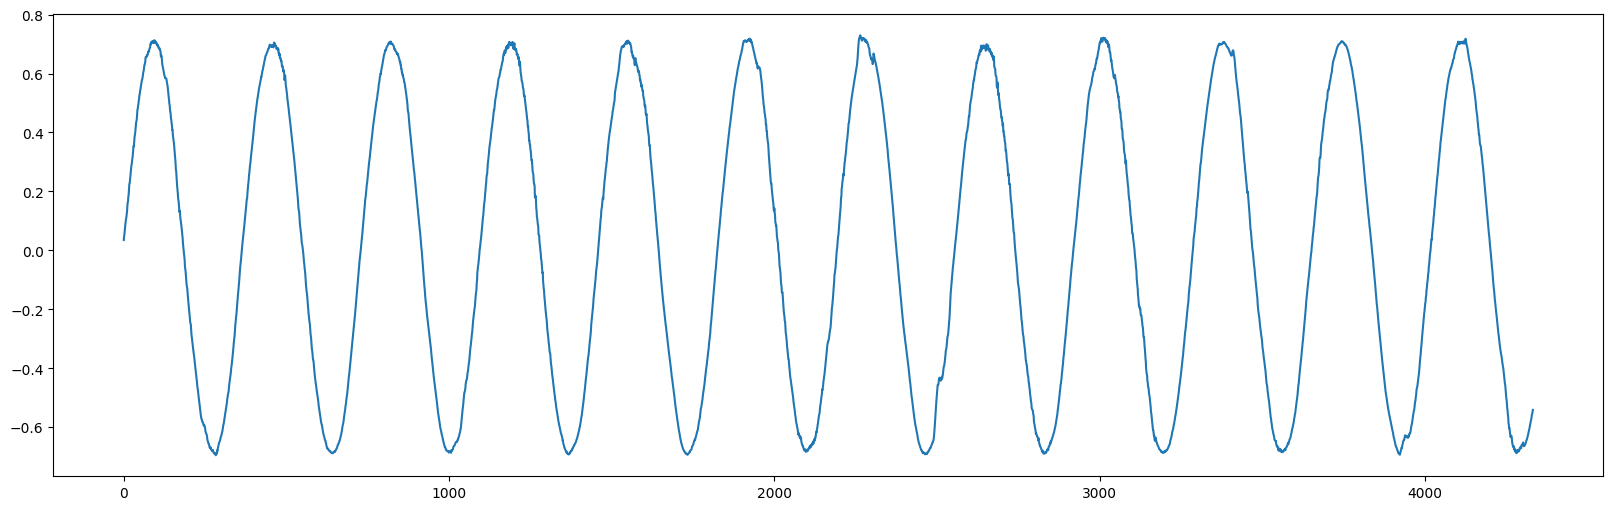

In [35]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(train_tcn_pred_pressure.numpy().squeeze())

### Train data for kNN

In [36]:
knn_features_temp = np.concatenate((np.expand_dims(train['ScaledTemp'].values[50:], 1), np.expand_dims(train['Train Pred Temperature'].values[50:], 1), train_tcn_pred.numpy()), axis = 1)

In [37]:
knn_features_humid = np.concatenate((np.expand_dims(train['ScaledHumid'].values[50:], 1), np.expand_dims(train['Train Pred Humidity'].values[50:], 1), train_tcn_pred_humid.numpy()), axis = 1)

In [38]:
knn_features_pressure = np.concatenate((np.expand_dims(train['ScaledPressure'].values[50:], 1), np.expand_dims(train['Train Pred Pressure'].values[50:], 1), train_tcn_pred_pressure.numpy()), axis = 1)

In [39]:
knn_train_features=np.concatenate((knn_features_temp,knn_features_humid, knn_features_pressure), axis = 1)

In [40]:
knn_train_features.shape

(4333, 9)

In [41]:
knn_model = KNN()
knn_model.fit(knn_train_features)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

### Test Data and kNN

In [42]:
test_data = np.expand_dims(test['ScaledTemp'].values, -1)
test_data = np.concatenate((train_data[-50:], test_data),0)
Y  = np.zeros((test_data.shape[0]-50, 50, 1))
print(Y.shape)
for i in range(Y.shape[0]):
    Y[i] = test_data[i:i+window_length]
#Y = np.concatenate((X[-1:], Y), axis=0)
test_tcn_pred = model_tcn(Y)

(1096, 50, 1)


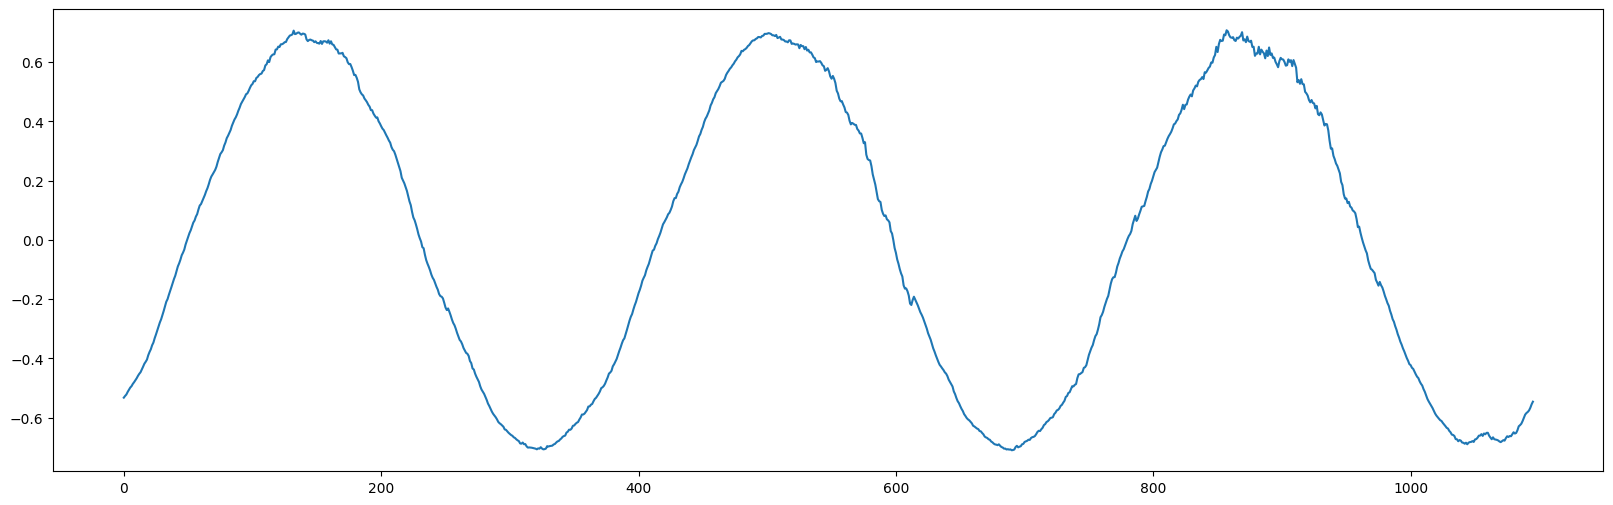

In [43]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(test_tcn_pred.numpy().squeeze())

In [44]:
test_data = np.expand_dims(test['ScaledHumid'].values, -1)
test_data = np.concatenate((train_data[-50:], test_data),0)
Y  = np.zeros((test_data.shape[0]-50, 50, 1))
print(Y.shape)
for i in range(Y.shape[0]):
    Y[i] = test_data[i:i+window_length]
#Y = np.concatenate((X[-1:], Y), axis=0)
test_tcn_pred_humid = model_tcn_humid(Y)

(1096, 50, 1)


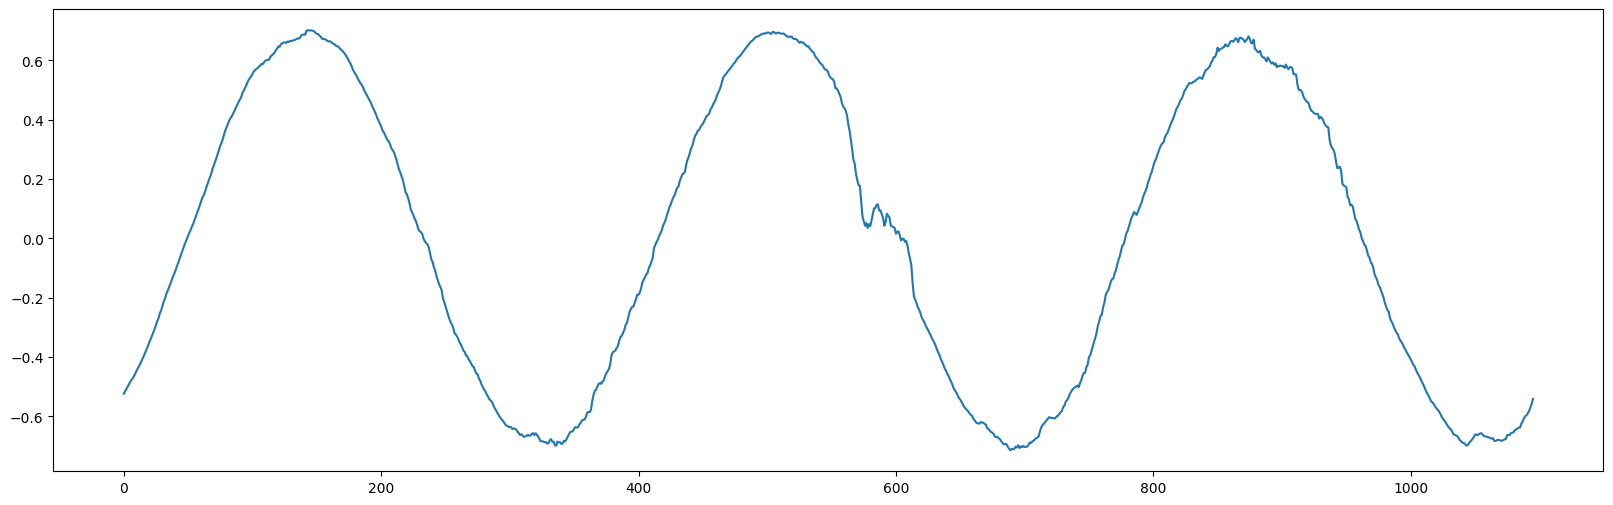

In [45]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(test_tcn_pred_humid.numpy().squeeze())

In [46]:
test_data = np.expand_dims(test['ScaledPressure'].values, -1)
test_data = np.concatenate((train_data[-50:], test_data),0)
Y  = np.zeros((test_data.shape[0]-50, 50, 1))
print(Y.shape)
for i in range(Y.shape[0]):
    Y[i] = test_data[i:i+window_length]
#Y = np.concatenate((X[-1:], Y), axis=0)
test_tcn_pred_pressure = model_tcn_pressure(Y)

(1096, 50, 1)


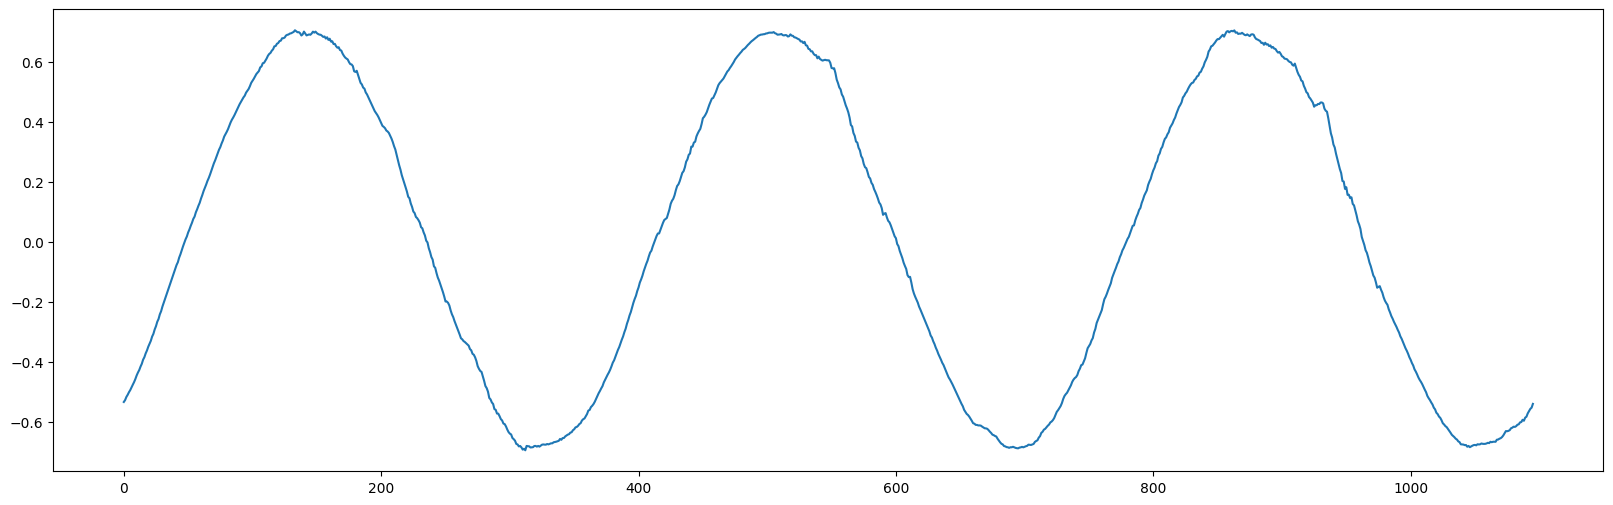

In [47]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(test_tcn_pred_pressure.numpy().squeeze())

In [48]:
knn_test_features_temp = np.concatenate((np.expand_dims(test['ScaledTemp'].values, 1), np.expand_dims(test['Test Pred Temperature'].values, 1), test_tcn_pred.numpy()), axis = 1)

In [49]:
knn_test_features_humid = np.concatenate((np.expand_dims(test['ScaledHumid'].values, 1), np.expand_dims(test['Test Pred Humidity'].values, 1), test_tcn_pred_humid.numpy()), axis = 1)

In [50]:
knn_test_features_pressure = np.concatenate((np.expand_dims(test['ScaledPressure'].values, 1), np.expand_dims(test['Test Pred Pressure'].values, 1), test_tcn_pred_pressure.numpy()), axis = 1)

In [51]:
knn_test_features=np.concatenate((knn_test_features_temp,knn_test_features_humid, knn_test_features_pressure), axis = 1)

In [52]:
knn_preds = knn_model.predict(knn_test_features)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, knn_preds)

array([[649, 399],
       [  0,  48]], dtype=int64)

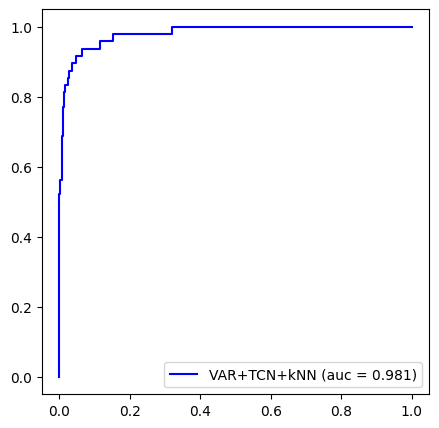

In [54]:
test_prediction_scores = knn_model.predict_proba(knn_test_features)[:,1]
auc_roc_VT3yr = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr_VT3yr, tpr_VT3yr, thresholds_VT3yr = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN_VT3yr = auc(fpr_VT3yr,tpr_VT3yr)


plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_VT3yr, tpr_VT3yr, linestyle='-', color='b', label='VAR+TCN+kNN (auc = %0.3f)' % auc_kNN_VT3yr)
plt.legend()

In [55]:
thresholds_VT3yr

array([1.828066  , 0.828066  , 0.14981636, 0.13827137, 0.13762688,
       0.13025699, 0.12857229, 0.10960415, 0.0947638 , 0.09349921,
       0.08970966, 0.08945365, 0.08824074, 0.08788213, 0.08626147,
       0.08609003, 0.08594422, 0.08233641, 0.08226604, 0.08225893,
       0.08167113, 0.07983108, 0.0778248 , 0.07506504, 0.07488795,
       0.07098785, 0.07088417, 0.06265219, 0.06247518, 0.05753106,
       0.05730443, 0.03782609, 0.03781732, 0.00400821])

In [56]:
j_statistic_VT3yr = tpr_VT3yr - fpr_VT3yr
optimal_threshold_VT3yrindex = np.argmax(j_statistic_VT3yr)
optimal_threshold_VT3yr = thresholds_VT3yr[optimal_threshold_VT3yrindex]

In [57]:
optimal_threshold_VT3yr

0.07088417350277029

In [58]:
# calculating a confusion matrix after obtaining an ROC curve and AUC (Area Under the Curve), it is common to use the optimal threshold determined from the ROC curve.

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, knn_preds)

array([[649, 399],
       [  0,  48]], dtype=int64)

In [80]:
#399 type1 error.

### Modifying the Prediction( 1 year seen and predict 1 year , so on)

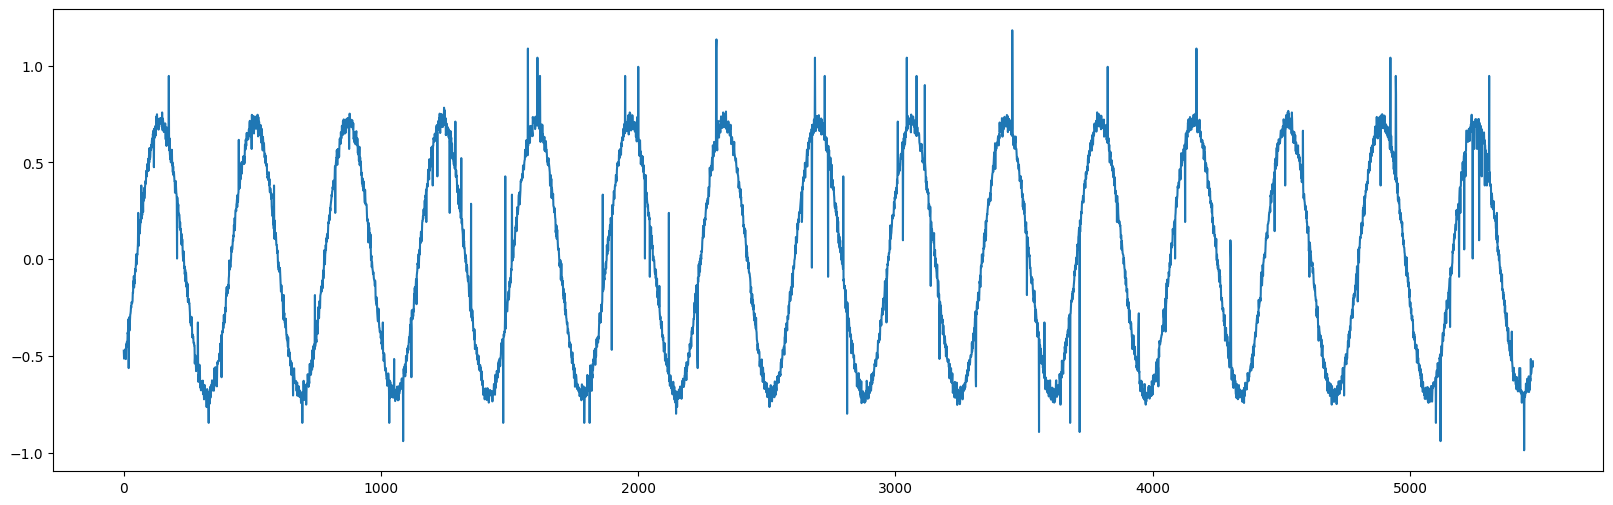

In [60]:
plt.plot(np.concatenate((train['ScaledTemp'].values, test['ScaledTemp'].values)))

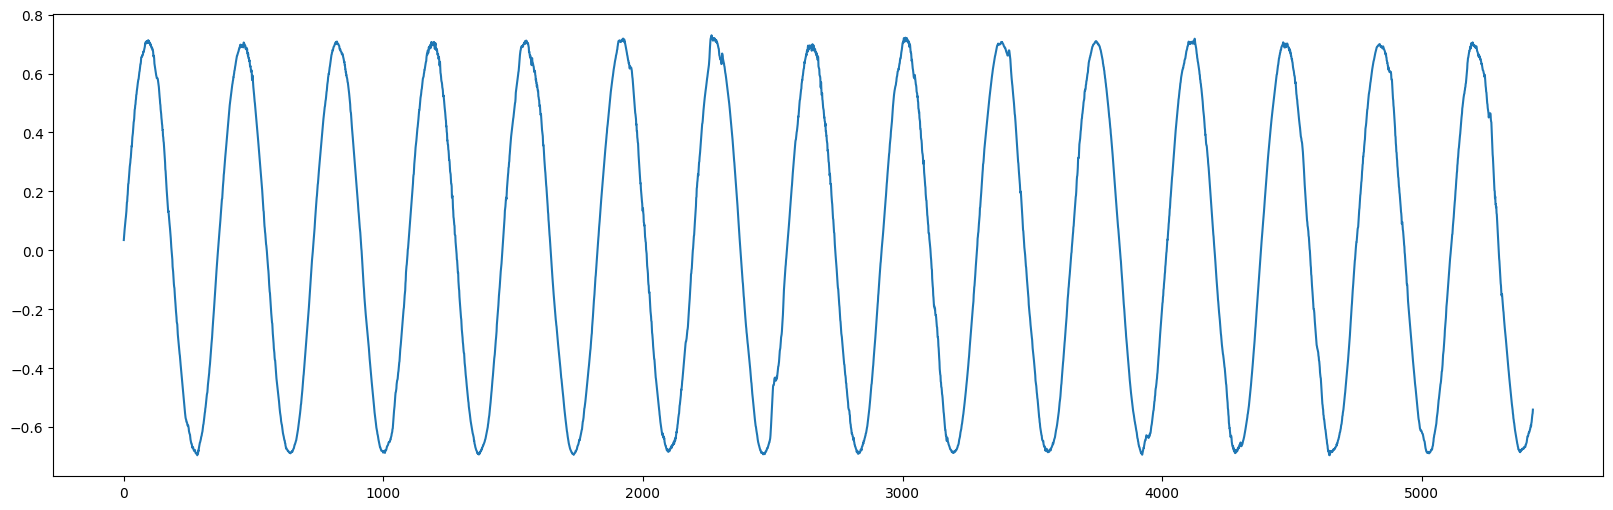

In [61]:
plt.plot(np.concatenate((train_tcn_pred_pressure.numpy().squeeze(), test_tcn_pred_pressure.numpy().squeeze())))

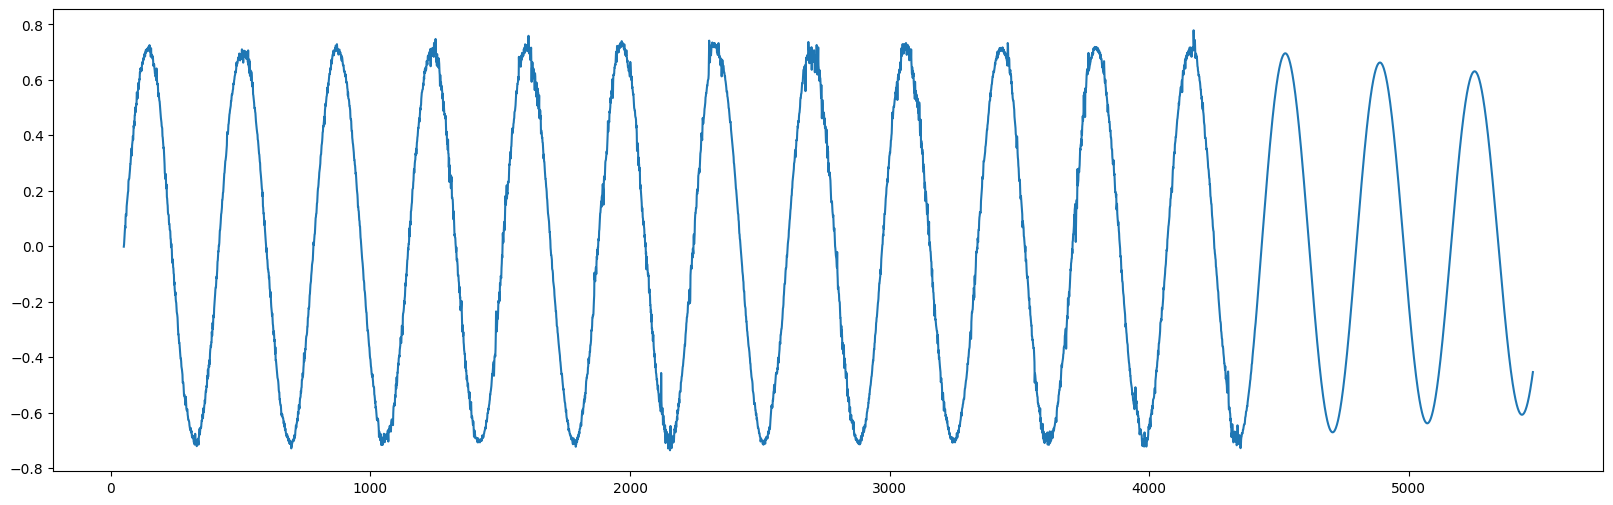

In [62]:
plt.plot(np.concatenate((train['Train Pred Temperature'].values, test['Test Pred Temperature'].values)))

In [63]:
# VAR has a dampning effect when 3 year test data used.

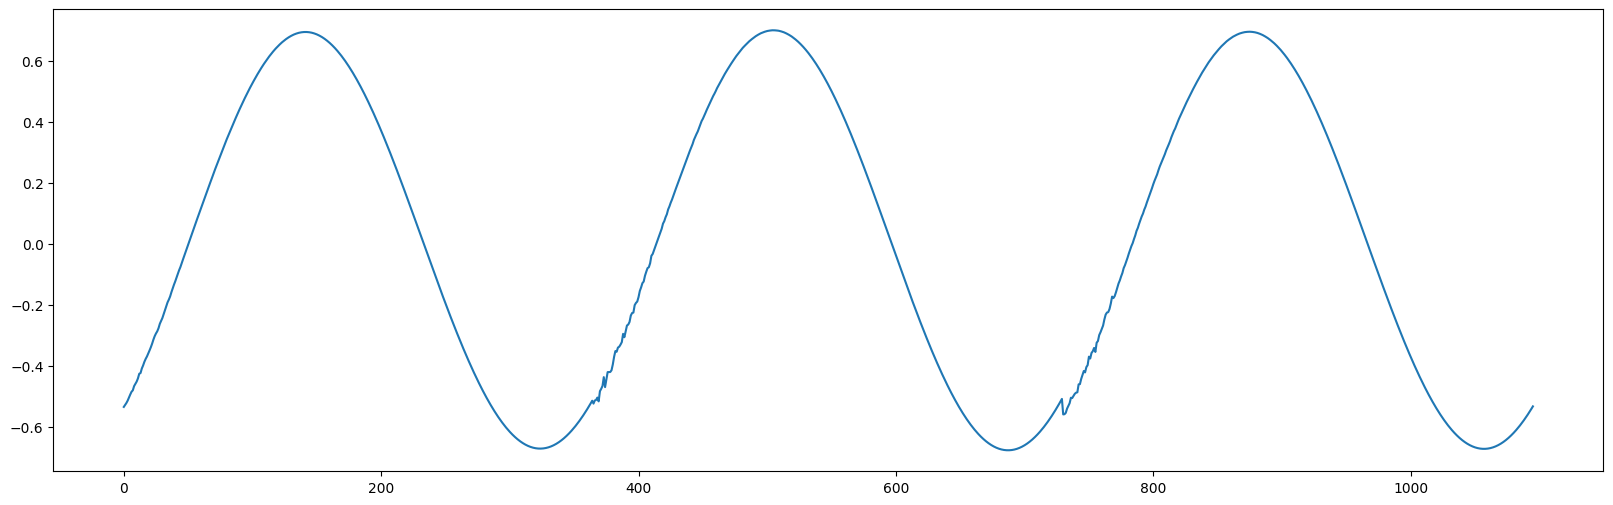

In [64]:
pred_days=  [365, 365, 366]
past = train[cols].values[-50:]
temp_preds = []
preds  =[]
cumul = 0
for i, days in enumerate(pred_days):
    cumul += days
    year_pred = fitted_model.forecast(y = past, steps= days)
    temp_preds.append(year_pred[:,0])
    preds.append(year_pred)
    past = test[cols].values[cumul-50:cumul]
    #past = test[cols].values[680:730]
plt.plot(np.concatenate(tuple(temp_preds)))

In [65]:
var_preds = np.concatenate((tuple(preds)))
knn_test_features_temp = np.concatenate((np.expand_dims(test['ScaledTemp'].values, 1), np.expand_dims(var_preds[:,0], 1), test_tcn_pred.numpy()), axis = 1)
knn_test_features_humid = np.concatenate((np.expand_dims(test['ScaledHumid'].values, 1), np.expand_dims(var_preds[:,1], 1), test_tcn_pred_humid.numpy()), axis = 1)
knn_test_features_pressure = np.concatenate((np.expand_dims(test['ScaledPressure'].values, 1), np.expand_dims(var_preds[:,2], 1), test_tcn_pred_pressure.numpy()), axis = 1)
knn_test_features=np.concatenate((knn_test_features_temp,knn_test_features_humid, knn_test_features_pressure), axis = 1)
knn_preds = knn_model.predict(knn_test_features)
confusion_matrix(ground_truth_test, knn_preds)

array([[901, 147],
       [  0,  48]], dtype=int64)

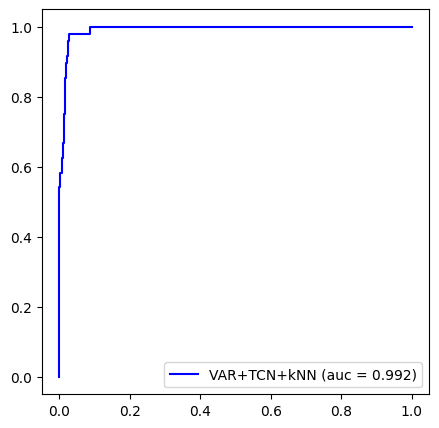

In [66]:
test_prediction_anomaly_scores = knn_model.predict_proba(knn_test_features)[:,1]
auc_roc_hmad = roc_auc_score(ground_truth_test, test_prediction_anomaly_scores)
fpr_anomaly, tpr_anomaly, thresholds_anomaly = roc_curve(ground_truth_test, test_prediction_anomaly_scores)
auc_kNN_anomaly = auc(fpr_anomaly,tpr_anomaly)


plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_anomaly, tpr_anomaly, linestyle='-', color='b', label='VAR+TCN+kNN (auc = %0.3f)' % auc_kNN_anomaly)
plt.legend()

### Threshold Modification with Youden's J statistic(max distance)

In [67]:
knn_model.predict_proba(knn_test_features).shape

(1096, 2)

In [68]:
thresholds_anomaly

array([1.82118213, 0.82118213, 0.14349956, 0.13934284, 0.13703333,
       0.1311748 , 0.12385421, 0.10960259, 0.10303612, 0.09419144,
       0.09394325, 0.08909979, 0.08846294, 0.08528019, 0.08269892,
       0.08254916, 0.08241223, 0.07587688, 0.07444088, 0.07415629,
       0.07374584, 0.07204933, 0.07141317, 0.07129811, 0.0699889 ,
       0.06816806, 0.06766408, 0.06717295, 0.06647145, 0.05985477,
       0.05949264, 0.05904286, 0.05811639, 0.05332687, 0.05285501,
       0.03788077, 0.03781732, 0.00273807])

In [69]:
#Youden's J statistic: Youden's J statistic is defined as the maximum vertical distance between the ROC curve and the diagonal line connecting (0,0) and (1,1). The threshold that corresponds to this maximum value is considered the optimal threshold.

In [70]:
j_statistic = tpr_anomaly - fpr_anomaly
optimal_threshold_index = np.argmax(j_statistic)
optimal_threshold = thresholds_anomaly[optimal_threshold_index]

In [71]:
optimal_threshold

0.05285500823901069

In [72]:
knn_model.threshold_ = optimal_threshold

In [73]:
knn_preds = knn_model.predict(knn_test_features)
confusion_matrix(ground_truth_test, knn_preds)

array([[767, 281],
       [  0,  48]], dtype=int64)

### Modifying Threshold to explore the changes

In [74]:
knn_model.threshold_ = 0.07167264 #optional best.

In [75]:
knn_preds = knn_model.predict(knn_test_features)
confusion_matrix(ground_truth_test, knn_preds)

array([[989,  59],
       [  1,  47]], dtype=int64)

In [76]:
knn_model.threshold_ = 0.06454141  #best threshold till now

In [77]:
knn_preds = knn_model.predict(knn_test_features)
confusion_matrix(ground_truth_test, knn_preds)

array([[944, 104],
       [  0,  48]], dtype=int64)

In [78]:
knn_model.threshold_ = 0.05602164

In [79]:
knn_preds = knn_model.predict(knn_test_features)
confusion_matrix(ground_truth_test, knn_preds)

array([[839, 209],
       [  0,  48]], dtype=int64)

### using domain information

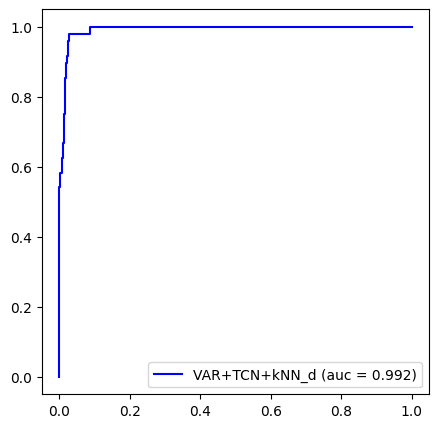

In [140]:
#Experiments done with kNN
# Define cost of false positives and false negatives
cost_fp = 11  # Cost of a false positive
cost_fn = 1  # Cost of a false negative

fpr_domainVarTcn, tpr_domainVarTcn, thresholds_domainVarTcn = roc_curve(ground_truth_test, test_prediction_anomaly_scores)
costs = cost_fp * fpr_domainVarTcn + cost_fn * (1 - tpr_domainVarTcn)

# Find the optimal threshold index
optimal_threshold_domainVarTcn_index = np.argmin(costs)
optimal_threshold = thresholds_domainVarTcn[optimal_threshold_domainVarTcn_index]

auc_domainVarTcn = auc(fpr_domainVarTcn,tpr_domainVarTcn)

# Plot the ROC curve
#plt.plot(fpr_domain, tpr_domain, label='ROC Curve')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
#plt.legend()
#plt.show()

#print("Optimal Threshold:", optimal_threshold)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_domainVarTcn, tpr_domainVarTcn, linestyle='-', color='b', label='VAR+TCN+kNN_d (auc = %0.3f)' % auc_domainVarTcn)
plt.legend()

In [142]:
print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.066471449528499


In [143]:
thresholds_domainVarTcn

array([1.82118213, 0.82118213, 0.14349956, 0.13934284, 0.13703333,
       0.1311748 , 0.12385421, 0.10960259, 0.10303612, 0.09419144,
       0.09394325, 0.08909979, 0.08846294, 0.08528019, 0.08269892,
       0.08254916, 0.08241223, 0.07587688, 0.07444088, 0.07415629,
       0.07374584, 0.07204933, 0.07141317, 0.07129811, 0.0699889 ,
       0.06816806, 0.06766408, 0.06717295, 0.06647145, 0.05985477,
       0.05949264, 0.05904286, 0.05811639, 0.05332687, 0.05285501,
       0.03788077, 0.03781732, 0.00273807])

In [144]:
knn_model.threshold_ = 0.066471449528499

In [145]:
knn_preds = knn_model.predict(knn_test_features)
confusion_matrix(ground_truth_test, knn_preds)

array([[956,  92],
       [  1,  47]], dtype=int64)